# Searchlights <a name="searchlights"></a>

In univariate analyses there is a distinction between whole-brain and [ROI-based](https://doi.org/10.1093/scan/nsm006) analyses. When done correctly, whole-brain univariate analyses allow you to identify, in an unbiased and data-driven way, regions of the brain that differ between experimental conditions. Compare this to what we have done with multivariate classification: up to this point we have taken ROIs (e.g., FFA, PPA, even the whole brain) and looked at the pattern of activity across voxels. Using these procedures we have been able to determine whether these voxels collectively contain information about different conditions. However, throughout these analyses it has been unclear whether a subset of these voxels have been driving classification accuracy. Although we could use the weights to indicate which voxels are important, weights alone do not always convey the influence of individual voxels. In other words, we have been unable to say with certainty *where* in the brain there are representations that distinguish between conditions. 

A searchlight is a spatial moving window that exhaustively searches the brain in order to localize representations. Running a searchlight is computationally intensive because it involves running a separate multivariate analysis for every voxel in the brain. Imagine doing your feature selection, hyper-parameter optimization, and cross-validation 100,000 times or more. Fortunately, [BrainIAK](http://brainiak.org/) (see introductory [article](https://apertureneuropub.cloud68.co/articles/42/)) contains a procedure that efficiently carves up brain data into appropriate chunks and distributes them across the computational resources available. 

For more information on the searchlight technique, read this comprehensive [NeuroImage Comment](https://doi.org/10.1016/j.neuroimage.2013.03.041) which also includes citations to landmark papers on the topic. 

## Goal of this script

1. Learn how to perform a whole-brain searchlight.  
2. Learn how to replace the kernel used inside the searchlight.  
3. Use batch scripts, SLURM, and MPI to run searchlight on compute clusters.
4. Run searchlight on a face-scene dataset.

## Table of contents

1. [Searchlight workflow](#sl_wf)  
>1.1 [Data preparation](#data_prep)  
>1.2 [Executing the searchlight workflow](#exe_wf)   
>1.3 [Executing on multiple subjects](#multi_subj)
2. [Running searchlight analyses on a cluster](#submitting_searchlights)  
>2.1 [Distributing jobs with parallel computing](#ranks)

Exercises

>[1](#ex1)   [2](#ex2)  [3](#ex3)  [4](#ex4)  [5](#ex5)  [6](#ex6)  [7](#ex7)  [8](#ex8)  [9](#ex9) [10](#ex10) [11](#ex11) [12](#ex12)

[Novel Contribution](#novel)


### Dataset <a id="data-set"></a> 

For this script we will use the face/scene dataset from [Wang et al. (2015)](https://doi.org/10.1016/j.jneumeth.2015.05.012), who in turn used localizer data from [Turk-Browne et al. (2012)](https://doi.org/10.1523/JNEUROSCI.0942-12.2012).

Localizer details from Turk-Browne et al. (2012):

    Subjects also completed a functional localizer run lasting 6 minutes, 6 seconds. ... The localizer run alternated between six repetitions each of scene and face blocks (Turk-Browne et al., 2010). Blocks contained 12 stimuli presented for 500 ms every 1500 ms. The 18 s of stimulation was followed by 12 s of fixation before the next block. Subjects made the same indoor/outdoor judgment for scenes, and a male/female judgment for faces.


## 1. Searchlight workflow <a id="sl_wf"></a>

Running a searchlight is computationally intensive and complex, involving multiple steps. To show how the searchlight functionality in BrainIAK works, we will walk through the steps needed to perform a simple searchlight that can be run in this notebook before moving onto a real example that requires submitting the job to a cluster, where it will have access to more computational resources. This simple workflow takes the following steps:

>1. [Data preparation](#data_prep)
>2. [Set the searchlight parameters](#set_param)
>3. [Create the searchlight object](#create_obj)
>4. [Create our classification kernel](#create_kernel)
>5. [Execute the searchlight](#exec_sl)


However, before we start, there are a few things that you should know about searchlights. Think of a searchlight as a processing step in which you pull out a certain size chunk of your data and then perform a kernel operation (specified by a function you write). You can use any kernel on this chunk of data interchangeably. Critically, **the searchlight function does not specify the analysis you want to perform; all it does is carve up the data.**

**Computational demand and parallelization**

As mentioned before, searchlights are computationally intensive, so we need to be aware of the kind of computational burden this analysis imposes. With each subject, we want to perform the operation thousands of times (once for each of their brain voxels). If we were to run this serially (meaning, a single searchlight at a time), *even if each operation only took 1 s to complete*, the analysis would take multiple days for *just one* participant. With nested cross-validation or other recursive steps, the full analysis could take months or years -- far beyond the due date for this assignment!

Fortunately, the searchlight function in BrainIAK intelligently parallelizes your data to give you a considerable and scalable speed boost. Parallelization is the idea that when two or more computational tasks can be completed independently (because they don't interact in any way), these tasks can be run simultaneously on different cores. Note: we refer to cores as our unit of serial processing, although there are other parallelizations available within-core, such as threads or even multiple instructions within thread. The nice thing about parallelization is that it is scalable: in general, a job parallelized across 10 cores will run up to 10 times faster than on one core. For reference, your computer likely has 2, 4, or more cores, so you could speed up processing if you recruited all of these resources (and shut down all other types of background processing). 
<div class="alert alert-block alert-info">
So remember, the two main things that determine the speed of a searchlight: **the kernel algorithm** and the **amount of parallelization**.
</div>

**How does the BrainIAK searchlight work?**

To analyze data efficiently, it is important to understand how the Searchlight function in BrainIAK works. You must provide the function with a numpy volume of 4D data and a binary mask of brain voxels, which tells the function which of the voxels in that 4D volume correspond to voxels inside the brain. The searchlight code simply searches for every voxel in the mask that is equal to 1 and then centers a searchlight around this. This means that for every value of 1 in your mask, the searchlight function will apply your kernel function to the corresponding voxel (and those around it) in the 4D volume. Hence when writing the kernel you need to keep in mind that the input data the function receives are not the size of the original data but instead the size of the searchlight radius. In other words, you might give the searchlight function a brain and mask volume that is 64x64x64 but each kernel operation only runs on a data and mask volume that is 3x3x3 (or whatever your searchlight radius is). 

**How to start using a searchlight? Small!**

When getting used to searchlights it is encouraged that you scale up your code gently. This is to prevent the possibility that you run a searchlight that takes a very long time to finish only to find there was a small error (which happens a lot). Instead it is better to write a simple function that runs quickly so you can check if your code works properly before scaling up. A simple workflow for testing your searchlight (and estimating how long your searchlight would take on a bigger dataset) would be this:

1. Create a brain mask with one voxel and run the searchlight interactively (like we are doing now, using a notebook) to check whether the code works.
2. Use timestamps to extract the execution time.  
3. Print the number of voxels that are passed to the searchlight kernel (the one voxel and its neighbors).  
4. Run the searchlight as a job on the smallest unit of real data you have (a single run or single participant).
5. Check the runtime and memory usage of this searchlight.

Taking our own advice, we are going to write a searchlight script below to perform a very simple searchlight. In fact, we are only going to run this searchlight on one voxel in the brain so that we can see whether our code is working and how long each kernel operation would take. After we have familiarized ourselves with the way searchlights work on a small scale, we will then graduate to full-scale analyses using batch scripts and cluster computing.

In [1]:
import warnings
import sys 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
# Import libraries
import nibabel as nib
import numpy as np
import os 
import time
import glob
from nilearn import plotting
from brainiak.searchlight.searchlight import Searchlight
from brainiak.fcma.preprocessing import prepare_searchlight_mvpa_data
from brainiak import io
from pathlib import Path
from shutil import copyfile

# Import machine learning libraries
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.svm import SVC

import matplotlib.pyplot as plt
import seaborn as sns 

# Set printing precision
np.set_printoptions(precision=2, suppress=True)

%matplotlib inline
sns.set(style = 'white', context='notebook', rc={"lines.linewidth": 2.5})
sns.set(palette="colorblind")

## 1.1 Data preparation <a id="data_prep"></a>
Prepare data for a single participant using a similar pipeline to what we've been using previously. The critical change needed here is the shape of the data: in the past we wanted a time by voxel matrix, but the input to BrainIAK's searchlight is a 4D volume.


### 1.1.1 Helper functions <a id="helper"> </a>

To make it easy for you to achieve the main goals of this notebook, we have created helper functions that perform data extraction from nifti file data, format them into arrays, and prepare the data for the searchlight function.

In [2]:
from utils import fs_data_dir, results_path

print(f'data dir = {fs_data_dir}') 

data dir = /gpfs/gibbs/project/cmhn/data/face_scene/


In [3]:
# Preprocess the raw data and save it to a location 
def preprocess_and_save_data(fs_data_dir, output_path):
    
    # Set paths
    suffix = 'bet.nii.gz'
    wb_mask_file =  f'{fs_data_dir}/mask.nii.gz' # whole brain mask
    fs_epoch_file = f'{fs_data_dir}/fs_epoch_labels.npy' # face/scene epoch labels   
    
    # Load in the image files from directory `fs_data_dir` that end with a given suffix.
    images = io.load_images_from_dir(in_dir=fs_data_dir, suffix=suffix)
    
    # Grab the filenames that correspond with these images.
    image_file_names = sorted(glob.glob(f"{fs_data_dir}/*{suffix}")) 
    
    # Load epoch file.
    epoch_list = io.load_labels(fs_epoch_file)
    
    # Get some variable information from the epoch list
    n_subjects, n_conditions, n_epochs, n_TRs = np.shape(epoch_list)
    
    # Normalize and format the data.
    bold_data_raw, labels = prepare_searchlight_mvpa_data(images, epoch_list)
    labels = np.array(labels) 
    # Note: `labels` and `bold_data_raw` are stacked events for all subjects.
    # That's why len(labels) = n_subjects * n_epochs
    
    # Load the whole brain mask file and determine which voxels are in the brain. 
    whole_brain_mask = nib.load(wb_mask_file).get_fdata()
    coords = np.where(whole_brain_mask !=0)[0]  # Where are the nonzero values?
    
    # Copy the whole brain mask file.
    copyfile(wb_mask_file, f"{output_path}/wb_mask.nii.gz")
    
    # Loop through all the subjects.
    # We now are going to break the data and labels down for each subject and save independently.
    for sub_id in range(n_subjects): 
        sub = f'sub-{sub_id+1:02d}'
        
        # Load in the NIfTI file so we can get some information about the image.
        nii = nib.load(image_file_names[sub_id])
        affine  = nii.affine  # Like the affine, which defines the orientation of the data.
        dimensions = nii.header.get_zooms() # And dimensions of the voxels in millimeters.
        
        # Extract the bold data and corresponding labels for this subject.
        this_subject_indices = np.arange(sub_id * n_epochs, (sub_id + 1) * n_epochs)
        data_i = bold_data_raw[:, :, :, this_subject_indices]
        label_i = labels[this_subject_indices]

        # Save data in one directory per subject.
        output_dir = os.path.join(output_path, sub)
        os.makedirs(output_dir, exist_ok=True)
        bold_nii = nib.Nifti1Image(data_i, affine)
        bold_nii.header.set_zooms(dimensions)
        nib.save(bold_nii, f'{output_dir}/data.nii.gz') 
        np.save(f'{output_dir}/label.npy', label_i)
        print(f'saved {output_dir}')

In [4]:
# Load and prepare data for one subject.
def load_fs_data(data_path, sub_id, mask=None):
    # Find the file path
    sub = f'sub-{sub_id:02d}'
    data_dir = f'{data_path}/{sub}'
    data_file = f'{data_dir}/data.nii.gz'
    label_file =  f'{data_dir}/label.npy'
    
    if not mask:
        mask = 'wb'
    mask_file = f'{data_path}/{mask}_mask.nii.gz'
    
    # Load bold data and some header information so that we can save searchlight results later.
    nii = nib.load(data_file)
    bold_data = nii.get_fdata()
    affine_mat = nii.affine
    dimensions = nii.header.get_zooms() 
    
    # Load label
    label = np.load(label_file)

    # Load mask
    brain_mask = nib.load(mask_file).get_fdata()

    return bold_data, label, brain_mask, affine_mat, dimensions

<a id="ex1"></a>
**Exercise 1:** Why does the input to a searchlight analysis need to be 4D rather than 2D? 

**A:**  
The brain is in 3D and the regions being looked at by the searchlight analysis are 3D masks. It would be preferable to preserve the image in 3D and add the time dimension than reduce the 3D to an array of voxels before adding the time dimension so that we don't have to keep track of where the points clustered near each other in 3D space are actually located relative to one another both in 3D and in 1D. Hence, since we are running a searchlight analysis on the whole brain, it is simpler and better to add the time dimension to the entire 3D image and end up with the fMRI data be preserved in 4D and fed directly into the searchlight analysis.

### 1.1.2 Create a directory structure<a id="helper"> </a>

We strongly recommend storing the data and results generated by the analysis in separate directories from the raw data (here we have enforced this by making the raw data directory read-only). On clusters these kinds of intermediate products should be stored on high-speed `scratch` disks. Typically, once your analysis is finished, you would copy the results and any important intermediate steps back to more permanent storage like your home directory or a project directory.

<div class="alert alert-block alert-warning">
Just like a whiteboard is wiped regularly, scratch storage is typically erased after a month or two. Moreover, scratch space is not backed up, so you could commit your work regularly, at a minimum after every session.
</div>

Please specify the path to a useable `scratch` folder:

In [5]:
# This is your scratch directory - all data here gets deleted after 60 days
scratch_folder =  os.path.expanduser("~/palmer_scratch/")

# Set up directories
# Preprocessed data path
data_path = os.path.expanduser(scratch_folder + '/brainiak_results/searchlight_data')
os.makedirs(data_path, exist_ok=True)
    
# Make directory to save results
output_dir = os.path.expanduser(scratch_folder + '/brainiak_results/searchlight_results')
os.makedirs(output_dir, exist_ok=True)

**Note that if you change the directory names here you will need to update them in the searchlight.py script later on**

### 1.1.3 Loading, normalizing, and saving the data<a id="helper"> </a>

The function `preprocess_and_save_data` will normalize and save the data to `searchlight_data`. Some important points to note about this function.  
>1. `io.load_images_from_dir(data_dir, suffix)` : This function creates a list of files that need to be loaded. You can load multiple subjects data at once.  
>2. `io.load_boolean_mask`: Loads a whole brain mask.  
>3. `prepare_searchlight_mvpa_data`: Normalizes and concatenates data from all subjects into a list of arrays. It also concatenates the labels from each subject. Some analysis methods use data across subjects and this step ensures that you are ready for either option.  
>4. `epoch_list`: Specifies the timing of blocks from the different experimental conditions [participant,condition,block index,time].

(18, 2, 12, 244)


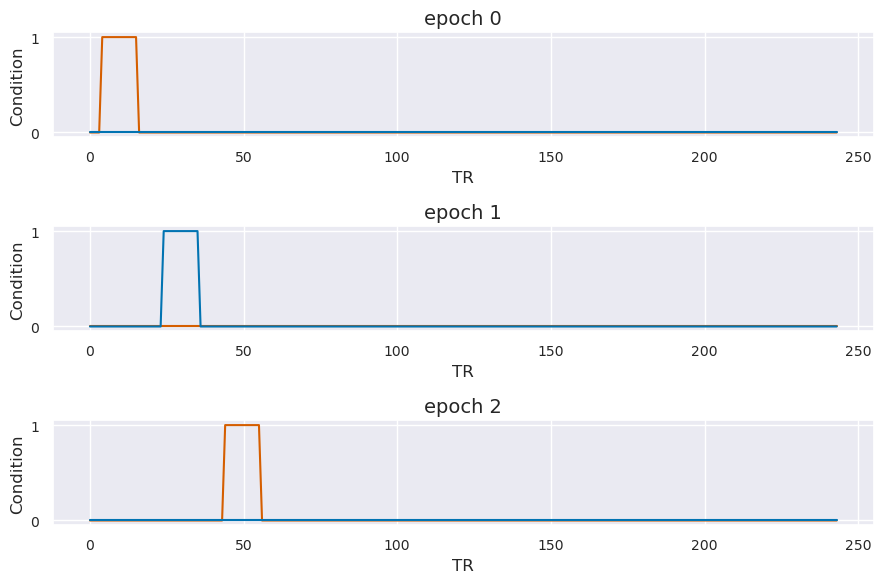

In [6]:
# Before preprocessing the data, let's take a look at the structure of the raw epoch file.
fs_epoch_file = f'{fs_data_dir}/fs_epoch_labels.npy'

# Read in the epoch data from "fs_epoch_labels.npy"
epoch_label = np.load(fs_epoch_file)

# Inspect the shape of the numpy array. Should be (subjects, conditions, epoch_ids, TRs)
print(epoch_label.shape)

# Display the first 3 epochs separately as TR sequence in the first participant 
# Plot both conditions in the same subplot but with different colors
fig, ax = plt.subplots(3,1, figsize = (9, 6))
for ep in range(3):
    ax[ep].plot(epoch_label[0,0,ep,:],'r') # red for condition 0
    ax[ep].plot(epoch_label[0,1,ep,:],'b') # blue for condition 1
    ax[ep].set_xlabel("TR")
    ax[ep].set_title('epoch % s' % ep, fontsize=14)
    ax[ep].tick_params(axis='both', which='major', labelsize=10)
    ax[ep].set_yticks([0,1])
    ax[ep].set_ylabel("Condition")
fig.tight_layout()

In [7]:
# Call data preprocessing script. You only need to run this line once, even if you have re-run earlier cells.
# We recommend commenting this out after you run it for the first time!
preprocess_and_save_data(fs_data_dir, data_path)

saved /home/cmhn_ak2776/palmer_scratch//brainiak_results/searchlight_data/sub-01
saved /home/cmhn_ak2776/palmer_scratch//brainiak_results/searchlight_data/sub-02
saved /home/cmhn_ak2776/palmer_scratch//brainiak_results/searchlight_data/sub-03
saved /home/cmhn_ak2776/palmer_scratch//brainiak_results/searchlight_data/sub-04
saved /home/cmhn_ak2776/palmer_scratch//brainiak_results/searchlight_data/sub-05
saved /home/cmhn_ak2776/palmer_scratch//brainiak_results/searchlight_data/sub-06
saved /home/cmhn_ak2776/palmer_scratch//brainiak_results/searchlight_data/sub-07
saved /home/cmhn_ak2776/palmer_scratch//brainiak_results/searchlight_data/sub-08
saved /home/cmhn_ak2776/palmer_scratch//brainiak_results/searchlight_data/sub-09
saved /home/cmhn_ak2776/palmer_scratch//brainiak_results/searchlight_data/sub-10
saved /home/cmhn_ak2776/palmer_scratch//brainiak_results/searchlight_data/sub-11
saved /home/cmhn_ak2776/palmer_scratch//brainiak_results/searchlight_data/sub-12
saved /home/cmhn_ak2776/palm

In [8]:
# Load the data from the first subject
sub_id = 1
bold_vol, labels, whole_brain_mask, affine, dimensions = load_fs_data(data_path, sub_id)

print(affine)
print(dimensions)

[[ -3.5    0.     0.   110.25]
 [  0.     3.16  -2.14 -95.17]
 [  0.     1.5    4.52 -97.02]
 [  0.     0.     0.     1.  ]]
(3.5, 3.5, 5.0, 1.0)


<div class="alert alert-block alert-info">
<strong> What if I want to run searchlights in the individual subject space? </strong>
<br>
The current face-scene dataset used in this notebook is aligned to standard MNI space. Hence, it is fine to apply the same whole-brain mask to all subjects. Often, we would like to run searchlights in the individual subject space, for example, in previous notebooks we ran decoding on each individual subject's data (that had multiple runs). If that is the case, you can just load subject 4D data in, name it `bold_vol`, along with the subject specific mask named `whole_brain_mask`. We have provided a batch script `./07-searchlight/searchlight_single_subject.py` that implements within-subject searchlight analysis.
</div>

<a id="ex2"></a>
**Exercise 2.** What do the variables `affine` and `dimensions` (returned by `load_fs_data`) represent?  

**A**:  

The affine variable represents the affine transformation matrix that maps subject brain space to reference brain space. This is important for accurately visualizing brain data comparisons spatially across different scans.

The dimensions variable represents the dimensions of the brain image in millimeters. 


## 1.2 Executing the searchlight workflow<a id="exe_wf"></a>
### 1.2.1 Set searchlight parameters <a id="set_param"></a>

To run the [searchlight](http://brainiak.org/docs/brainiak.searchlight.html) function in BrainIAK you need the following parameters:  

1. **data** = The brain data as a 4D volume.  
2. **mask** = A binary mask specifying the "center" voxels in the brain around which you want to perform searchlight analyses. A searchlight will be drawn around every voxel in this mask with the value of 1. Hence, if you chose to use the whole-brain mask as the mask for the searchlight procedure, the searchlight may include voxels outside of your mask when the "center" voxel is at the border of the mask. It is up to you to decide whether then to include these results.  
3. **bcvar** = An additional variable which can be a list, numpy array, dictionary, etc. you want to **b**[road]**c**[ast] in your searchlight kernel. For instance, you might want to broadcast the condition labels so that you can determine to which condition each 3D volume corresponds. If you don't need to broadcast anything, e.g, when doing RSA, set this to 'None'.  
4. **sl_rad** = The size of the searchlight's radius, excluding the center voxel. This means the total volume size of the searchlight, if using a cube, is defined as: ((2 * sl_rad) + 1) ^ 3.  
5. **max_blk_edge** = When the searchlight function carves the data up into chunks, it doesn't distribute only a single searchlight's worth of data. Instead, it creates a block of data, with the edge length specified by this variable, which determines the number of searchlights to run within a job.  
6. **pool_size** = Maximum number of cores running on a block (typically 1).  

<a id="ex3"></a>
**Exercise 3:** Searchlights don't need to be cubes. What other shape(s) does BrainIAK support? How do you specify this?

**A:**  
The searchlight can be a sphere inscribed in a cube, a diamond inscribed in a cube, or a custom shape that is based on a custom mask. This is specified:  
brainiak.searchlight.searchlight.[SPECIFY CUBE, DIAMOND, BALL, OR CUSTOM MASK HERE]

In [9]:
# Make a mask of only one arbitrary voxel
small_mask = np.zeros(whole_brain_mask.shape)
target_voxel = (16,20,16)
small_mask[target_voxel] = 1

# Preset the variables to be used in the searchlight
data = bold_vol
mask = small_mask
bcvar = labels
sl_rad = 1
max_blk_edge = 5
pool_size = 1

# We will get back to these commands once we finish running a simple searchlight. 
# comm = MPI.COMM_WORLD
# rank = comm.rank
# size = comm.size

### 1.2.2 Create Searchlight Object  <a id="create_obj"></a>

In [10]:
# Create the searchlight object
sl = Searchlight(sl_rad=sl_rad, max_blk_edge=max_blk_edge)
print("Setup searchlight inputs")
print(f"Input data shape: {data.shape}")
print(f"Input mask shape: {mask.shape}")

# Distribute the information to the searchlights (preparing it to run)
sl.distribute([data], mask)

# Data that is needed for all searchlights is sent to all cores via the sl.broadcast function. In this example, we are sending the labels for classification to all searchlights.
sl.broadcast(bcvar)

Setup searchlight inputs
Input data shape: (64, 64, 26, 12)
Input mask shape: (64, 64, 26)


### 1.2.3 Define the function (a.k.a. "kernel") that needs to be computed <a id="create_kernel"></a>

Every searchlight needs a function to run called a "kernel." This is the function that you want to measure/classify your data with. This could perform classification, RSA, or any other computation that you wish.

*Nota bene:* The word "kernel" is used in multiple mathematical/computational contexts. In this notebook we use kernel to represent the function that is passed to the searchlight object.

In [11]:
# Set up a SVM kernel function
def calc_svm(data, sl_mask, myrad, bcvar):
    
    """
    Parameters
        data: a list of 4D arrays containing data of voxels within a searchlight (could be one subject or multiple subjects' data)
        sl_mask: a binary mask specifying the voxels at the centers of the searchlights.
        myrad: (integer) the radius of the searchlight
        bcvar: the data broadcast to each searchlight, used in the kernel calculation (here, the labels for SVC)
        
    Returns:
        accuracy: average classification accuracy after cross-validation
    """
    
    
    # Pull out the data.
    data4D = data[0]
    labels = bcvar # This is the data broadcasted to all your searchlights.
    
    bolddata_sl = data4D.reshape(sl_mask.shape[0] * sl_mask.shape[1] * sl_mask.shape[2], data[0].shape[3]).T

    # Check if the number of voxels is what you expect.
    if verbose:
        print(f"Searchlight data shape: {data4D.shape}")
        print(f"Searchlight data shape after reshaping: {bolddata_sl.shape}")
        print(f"Searchlight mask shape: {sl_mask.shape}")
        print(f"Searchlight mask (note that the center equals 1) {sl_mask}")
    
    t1 = time.time()
    clf = SVC(kernel='linear', C=1)
    scores = cross_val_score(clf, bolddata_sl, labels, cv=3)
    accuracy = scores.mean()
    t2 = time.time()
    
    if verbose:
        print(f'Kernel duration: {np.round((t2-t1),2)}')
    
    return accuracy

### 1.2.4 Execute the searchlight <a id="exec_sl"></a>

We execute the searchlight and save the results in brain space. Each searchlight result is assigned to the voxel that the searchlight is centered on. This array is then saved to a nifti volume using the following:

> `nib.Nifti1Image`: Created a nifti volume with the same size and in the same space (e.g. MNI) as the subject data.  
> `.header`: This gets header information from the subject data.  
> `.set_zooms`: Sets the voxel dimensions (e.g 1.5mm x 1.5mm x 1.5mm).  


In [12]:
# Start the clock to time searchlight.
begin_time = time.time()

print("Begin Searchlight")
verbose=True
sl_result = sl.run_searchlight(calc_svm, pool_size=pool_size)
verbose=False # if you want to print out all that information when you next run the searchlight kernel, you can set verbose to True
print("End Searchlight")

end_time = time.time()

# Print outputs.
print("Summarize searchlight results:")
print(f"Number of searchlights run: {len(sl_result[mask==1])}")
print(f"Accuracy for each kernel function: {sl_result[mask==1].astype('double')}")
print(f'Total searchlight duration (including start up time): {np.round((end_time - begin_time),2)}')

# Save the results to a .nii file.
output_name = os.path.join(output_dir, f'subj{sub_id}_SL_result.nii.gz')
sl_result = sl_result.astype('double')  # Convert the output into a precision format that can be used by other applications.
sl_result[np.isnan(sl_result)] = 0  # Exchange nans with zero to ensure compatibility with other applications.
sl_nii = nib.Nifti1Image(sl_result, affine)  # Create the volume image.
sl_nii.header.set_zooms(dimensions[:3]) # Set zooms in header.
nib.save(sl_nii, output_name)  # Save the volume.

Begin Searchlight
Searchlight data shape: (3, 3, 3, 12)
Searchlight data shape after reshaping: (12, 27)
Searchlight mask shape: (3, 3, 3)
Searchlight mask (note that the center equals 1) [[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 1. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]]
Kernel duration: 0.01
End Searchlight
Summarize searchlight results:
Number of searchlights run: 1
Accuracy for each kernel function: [0.83]
Total searchlight duration (including start up time): 0.01


<a id="ex4"></a>
**Exercise 4:** How large would the searchlight be if you set `sl_rad = 4`? (Please still use `sl_rad = 1` in the following exercises, we just want you to state the answer.)

**A:**  
it would be (4 * 2 + 1)^3 voxels (4*2 + 1 representing a dimension length of the cube.)

= 729 voxels

<a id="ex5"></a>
**Exercise 5:** Using the same parameters as above, around how long would it take to run the searchlight analysis on the whole brain?   
*Note: you'd only run the searchlight analysis on voxels that are in the brain.*

In [13]:
np.sum(whole_brain_mask)

34470.0

In [14]:
timefb = 34470 * 0.01
print(timefb)
print(timefb / 60)

344.7
5.745


**A:**  
it would take approximately 344.7 seconds = 5.7 minutes

<a id="ex6"></a>
**Exercise 6:** Scale up the ``small_mask`` variable to select 64 brain voxels (a 4x4x4 mini-brain) *including* the voxel in the example above. Call this mask ``my_small_mask``. *Hint: You are not changing the searchlight radius, just the brain mask that defines the searchlight centers.* 

In [15]:
# Insert code here
# Make a mask of only one arbitrary voxel

my_small_mask = np.zeros(whole_brain_mask.shape)
my_small_mask[14:18,18:22,14:18] = 1

# Preset the variables to be used in the searchlight
data = bold_vol
mask = my_small_mask
bcvar = labels
sl_rad = 1
max_blk_edge = 5
pool_size = 1

#Validate your code by uncommenting the following line
np.sum(my_small_mask) == 64

True

<a id="ex7"></a>
**Exercise 7:** Create a new function called `my_calc_svm` by modifying the `calc_svm` function in two ways:

1. Run only if there are at least 12 "brain" voxels from the mask in the 27-voxel searchlight centered on each of the 64 voxels specified in ``my_small_mask``, otherwise return `np.nan`. 
    * This could be useful if you wanted to ignore searchlights near the edge or corner of the brain where only part of the searchlight is in the brain.   

2. Perform nested cross-validation over the cost parameters for the linear SVM kernel. For reference, use the code you made for the classification notebook in week 5. 
    * In your inner loop, evaluate costs `C=[0.01, 0.1, 1, 10]` to select the best `C` value. 
    * Since we do not have run_ids to define outer cross-validation folds as in previous notebooks, use [StratifiedKFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html) to perform the cross-validation with `n_splits=3` in both the inner and outer loops.

**Make sure to include docstring commenting for your function** You can remove print statements from your function if you desire.

In [16]:
# Insert code here
def my_calc_svm(data, sl_mask, myrad, bcvar):
    
    """
    Parameters:
        data: list of 4D arrays of voxel activation over time
        sl_mask: binary mask specifying the centers of the searchlights
        myrad: an integer describing the radius of the searchlight
        bcvar: the data broadcast to each searchlight. This is used to calculate the kernel
    Returns: 
        accuracy: average classification accuracy post cross-validation
    """
    
    data4D = data[0]
    labels = bcvar

    Sbolddata = data4D.reshape(sl_mask.shape[0] * sl_mask.shape[1] * sl_mask.shape[2], data[0].shape[3]).T

    nvox = np.sum(sl_mask)

    if nvox < 12:
        return np.nan

    scores = []

    sp = StratifiedKFold(n_splits = 3)

    for train, test in sp.split(Sbolddata, labels):

        trainData = Sbolddata[train,:]
        trainLabel = labels[train]
        testData = Sbolddata[test,:]
        testLabel = labels[test]

        sp_train = StratifiedKFold(n_splits = 3)

        parameters = {'C': [0.01, 0.1, 1, 10]}

        inner_clf = GridSearchCV(
        SVC(kernel='linear'),
        parameters,
        cv=sp_train,
        return_train_score=True)

        inner_clf.fit(trainData, trainLabel)

        C_best_i = inner_clf.best_params_['C']

        classifier = SVC(kernel="linear", C = C_best_i)
        clf = classifier.fit(trainData, trainLabel)

        score = clf.score(testData, testLabel)
        scores.append(score) 

    accuracy = np.mean(scores)

    return accuracy

<a id="ex8"></a>
**Exercise 8:** Start with the code in 1.2.1 - 1.2.4 and implement your changes from Exercises 6 & 7 to run searchlight analysis on the new small mask. 

To recap, the changes should include:
1. Your new `my_small_mask`, which selects a 4x4x4 sub-volume of 64 voxels. 
2. Your new `my_calc_svm` kernel function, which only runs if there are at least 12 brain voxels from the mask in the searchlight and performs nested cross-validation. 

You will need to:
- Use the defined `my_small_mask`.
- Set the searchlight variables `data`,`mask`,`bcvar`,`sl_rad`,`max_blk_edge`, and `pool_size` (Make sure you leave `sl_rad = 1`!)  
- Create the searchlight object with these parameters.
- Distribute the necessary information to the searchlights.
- Broadcast necessary variables to the searchlight.Z
- Run the searchlight with your new `my_calc_svm` kernel function and `pool_size`. Make sure to time how long this step takes! 
- Save the result of `run_searchlight` in `my_sl_result`
- Print out the average/std accuracy of `run_searchlight` and the time elapsed using the following snippets:  
    - `print(f"Average searchlight accuracy: ", np.nanmean(my_sl_result[np.where(my_sl_result)]))`
    - `print(f"Standard deviation searchlight accuracy: ",np.nanstd(my_sl_result[mask!=0]))`
    - `print("Time elapsed: ", (t1-t0) / 60) `

In [17]:
# Insert code here
from sklearn.model_selection import StratifiedKFold

data = bold_vol
bcvar = labels
sl_rad = 1
max_blk_edge = 5
pool_size = 1

mask = my_small_mask

sl = Searchlight(sl_rad = sl_rad, max_blk_edge = max_blk_edge)

sl.distribute([data], mask)

sl.broadcast(bcvar)

t0 = time.time()

print("Begin Searchlight")
verbose = True

my_sl_result = sl.run_searchlight(my_calc_svm, pool_size=pool_size)
verbose = False
print("Searchlight Completed")

t1 = time.time()

print(f"Average searchlight accuracy: ", np.nanmean(my_sl_result[np.where(my_sl_result)]))
print(f"Standard deviation searchlight accuracy: ",np.nanstd(my_sl_result[mask!=0]))
print("Time elapsed: ", (t1-t0) / 60) 

Begin Searchlight
Searchlight Completed
Average searchlight accuracy:  0.6726190476190476
Standard deviation searchlight accuracy:  0.1895438491439364
Time elapsed:  0.07892802158991495


**Visualizing the data**

As you have seen, the output of the searchlight analysis is a 3D volume with the outputs of your kernel for each voxel it was centered on. The [nilearn package](http://nilearn.github.io/plotting/index.html) has multiple plotting options to allow you to view your data within python. This is good for quick visualizations but can be buggy and is not great for exploration. You can also view the data in other packages such as FSL or AFNI. If you followed the steps above, you likely won't see many bright spots because we only ran the searchlight on a tiny part of the brain. But if you look at the data in fslview, or try to plot the output image with matplotlib, you should see non-zero values at the coordinates of your small mask.

## 1.3 Executing on multiple subjects <a id="multi_subj"></a>

So far we have loaded data for one subject and performed within-subject analysis, similar to what we have done in notebooks 1-5 (but in standard MNI space). You can also perform searchlight analysis on a group of subjects. This requires making a list of subjects.

In [18]:
# Load 3 subjects
subjects = [1,2,3]
all_bold = [] # Each subject's data is an element in the list. BrainIAK will handle this format.
all_labels = []
all_affines = []
all_dimensions = []
for sub_id in subjects:
    bold_vol, labels, whole_brain_mask, affine, dimension = load_fs_data(data_path, sub_id)
    all_bold.append(bold_vol)
    all_labels.append(labels)
    all_affines.append(affine)
    all_dimensions.append(dimension)

# Make a mask of a 4 x 4 x 4 region
target_voxel = (16, 20, 16)
small_mask = np.zeros(whole_brain_mask.shape)
x,y,z = target_voxel
small_mask[x-2:x+2, y-2:y+2, z-2:z+2] = 1

# Preset the variables
data = all_bold
mask = small_mask
bcvar = all_labels
sl_rad = 1
max_blk_edge = 5
pool_size = 1

# Start the clock to time searchlight.
begin_time = time.time()

# Create the searchlight object.
sl = Searchlight(sl_rad=sl_rad,max_blk_edge=max_blk_edge)
print("Setup searchlight inputs:")
print(f"Number of subjects: {len(data)}")
print(f"Input data shape: {data[0].shape}")
print(f"Input mask shape: {mask.shape}")


# Distribute the information to the searchlights (preparing it to run).
sl.distribute(data, mask)
# Data that is needed for all searchlights is sent to all cores via the sl.broadcast function. 
# In this example, we are sending the labels for classification to all searchlights.
sl.broadcast(bcvar)

# Set up the kernel, in this case an SVM
def calc_svm(data, sl_mask, myrad, bcvar):
    accuracy = []
    # Loop over subject: 
    for idx in range(len(data)):
        # Pull out the data
        data4D = data[idx]
        labels = bcvar[idx]
        bolddata_sl = data4D.reshape(sl_mask.shape[0] * sl_mask.shape[1] * sl_mask.shape[2], data[0].shape[3]).T        
        clf = SVC(kernel='linear', C=1)
        scores = cross_val_score(clf, bolddata_sl, labels, cv=3)
        accuracy.append(scores.mean())   
    return np.array(accuracy)

# Execute searchlight on 3 subjects.
print("Begin Searchlight\n")
sl_result_3subj = sl.run_searchlight(calc_svm, pool_size=pool_size)
print("End Searchlight\n")
end_time = time.time()
print(f'Total searchlight duration (including start up time): {np.round((end_time - begin_time),2)}')

Setup searchlight inputs:
Number of subjects: 3
Input data shape: (64, 64, 26, 12)
Input mask shape: (64, 64, 26)
Begin Searchlight

End Searchlight

Total searchlight duration (including start up time): 1.05


**Sanity Check:**

To make sure that each subject is being processed correctly, we can compare the results by loading one subject alone vs. loading the same subject amongst three subjects.

In [19]:
# Run it on the first subject alone
data_1 = [all_bold[0]]
bcvar_1 = [all_labels[0]]
begin_time = time.time()

# Create the searchlight object
sl = Searchlight(sl_rad=sl_rad,max_blk_edge=max_blk_edge)

# Distribute the information to the searchlights (preparing it to run)
sl.distribute(data_1, mask)

# Data that is needed for all searchlights is sent to all cores via the sl.broadcast function. In this example, we are sending the labels for classification to all searchlights.
sl.broadcast(bcvar_1)

# Execute searchlight on the first subject
sl_result_1subj = sl.run_searchlight(calc_svm, pool_size=pool_size)
end_time = time.time()
print(f'Total searchlight duration (including start up time): {np.round((end_time - begin_time),2)}')

# Compare the results using 1 subject and 3 subjects.
# Extract the two accuracy maps.
accu_from_1 = np.concatenate(sl_result_1subj[np.where(small_mask>0)])
accu_from_3 = np.array([r[0] for r in sl_result_3subj[np.where(small_mask>0)]])

# Print them out to compare.
print(f"Accuracy for each kernel function from one subject:\n {accu_from_1}")

print(f"Accuracy for each kernel function from 3 subjects:\n {accu_from_3}")

# Compare using numpy.
print (f'Are the two arrays close: {np.allclose(accu_from_1, accu_from_3)}')

# Data format of the accuracy array
print ("Shape of the accuracy array: " + str(sl_result_3subj.shape))
print ("One element of the accuracy array: "+ str(np.array(sl_result_3subj[target_voxel]))) # each element has the accuracy for 3 subjecs

Total searchlight duration (including start up time): 0.36
Accuracy for each kernel function from one subject:
 [0.83 0.5  0.58 0.67 0.83 0.67 0.5  0.58 0.75 0.33 0.42 0.75 0.92 0.42
 0.5  0.58 1.   0.42 0.5  0.58 1.   0.5  0.67 0.75 0.92 0.67 0.75 1.
 0.92 0.67 0.67 0.75 0.58 0.42 0.42 0.5  0.83 0.42 0.67 0.67 0.92 0.75
 0.83 0.67 0.92 0.83 0.83 0.75 0.75 0.58 0.75 0.67 0.83 0.75 0.75 0.67
 1.   1.   0.75 0.83 0.83 1.   0.92 1.  ]
Accuracy for each kernel function from 3 subjects:
 [0.83 0.5  0.58 0.67 0.83 0.67 0.5  0.58 0.75 0.33 0.42 0.75 0.92 0.42
 0.5  0.58 1.   0.42 0.5  0.58 1.   0.5  0.67 0.75 0.92 0.67 0.75 1.
 0.92 0.67 0.67 0.75 0.58 0.42 0.42 0.5  0.83 0.42 0.67 0.67 0.92 0.75
 0.83 0.67 0.92 0.83 0.83 0.75 0.75 0.58 0.75 0.67 0.83 0.75 0.75 0.67
 1.   1.   0.75 0.83 0.83 1.   0.92 1.  ]
Are the two arrays close: True
Shape of the accuracy array: (64, 64, 26)
One element of the accuracy array: [0.83 0.5  0.5 ]


## 2. Running searchlight analyses on a cluster<a name="submitting_searchlights"></a>

**Note: If you are running this section in a non-cluster environment (shouldn't be the case since the data is on the cluster), the run-time for this section can be quite long. You can make an estimate of the run-time (see [exercise 5](#ex5) above) and plan accordingly.**

Running searchlight analyses through notebooks or interactive sessions isn't tractable for real studies. Although the example above ran quickly and without parallelization, we only performed 64 analyses. We are now going to write a script to run a searchlight as a "batch" job. To learn how to submit jobs, you need to know a bit about [slurm](https://research.computing.yale.edu/support/hpc/user-guide/slurm), the scheduling system we will be using on Grace.

To run a job, a good work flow is to have two scripts: One script that actually does the computation you care about (e.g., a python script like `my_script.py`) and a script that sets up the environment and specifies the job parameters (e.g., a bash script like `submit_my_script.sh`). The environment refers to the modules and packages you need to run your job. The job parameters refer to the partition you are going to use (`-p`), the number of cores (`-n`), the amount of memory (`-m`) and required time (`-t`). To run your job you then call the bash script with something like: `sbatch submit_my_script.sh` from the command line.

**Self-study:** Lucky for you we have already written the script needed here, called `submit_searchlight.sh`. This script is written in bash. Please explore this script (inside the `07-searchlight` directory) to get familiar with submitting jobs. It will be very useful for future analyses to customize it for your needs (using a text editor like nano or vim).

In [20]:
# Print the bash script for running searchlights
!cat 07-searchlight/submit_searchlight.sh

#!/usr/bin/env bash
# Input python command to be submitted as a job

#SBATCH --output=searchlight-%j.out
#SBATCH --job-name searchlight
#SBATCH -p day 
#SBATCH --reservation=cmhn
#SBATCH -t 1:00:00
#SBATCH --mem-per-cpu=4G
#SBATCH -n 2

# Set up the environment
module load miniconda
module load OpenMPI
conda activate /gpfs/gibbs/project/cmhn/share/conda_envs/mybrainiak

# Make script executable
chmod 700 ./searchlight.py

# Run the python script
srun --mpi=pmi2 ./searchlight.py


When a job starts, a log file named as `searchlight-%j.out` is automatically created in the same directory as your shell script. You can see any output from your script printed into the log file. You can print out the content of the log file in the terminal by running `cat searchlight-%j.out` from the 07-searchlight directory in the command line. You could also opne the file from the Jupyter Lab file tree. To check the status of your job you should use `squeue --me` at the command line. Sometimes your jobs won't run immediately because they are waiting in the queue. Conversely, don't submit too many jobs or your classmates won't be able to run theirs.

## 2.1 Distributing jobs with parallel computing<a name="ranks"></a>

When you parallelize an analysis across multiple cores, this typically means that each core will run the code independently (though there are ways for cores to communicate directly with each other). This means you will load in all of the data on each core. The searchlight function then notices that there are multiple cores running the same job and assigns different pieces of the data to each core for analysis. The message passing interface (MPI), the parallelizing framework used by BrainIAK and most high-performance computing applications, keeps track of each process by assigning it a rank, starting at 0. We provide a brief overview of ranks, cores, and nodes below.

<img src="imgs/nodes_process.jpg" width="300" height="300"/>


What is a rank? It is a process generated by the application that you are running. In the above figure "Process 1" can be considered to be rank=0 and "Process 2" rank=1. A rank can use more than one core on the cluster and is managed by MPI. Each rank also uses a part of the memory allocated. The cores and memory are part of the hardware belonging to a "node". A node is akin to a server. When you submit a job, you are requesting use of part of the node, or sometimes even the entire node. **Optimizing the memory, and number of cores for your batch job will lead to significant gains in run-time for your programs**.

MPI handles all communication between the ranks (or processes). This can occur within a single node, or if you have asked for lots of resources, this can even span multiple nodes. Each process can spawn multiple threads, and Open-MP handles communication between threads.


<img src="imgs/mpi_openmp.jpg" width="300" height="300"/>


**You do not need to configure any of the above. BrainIAK handles all the parallelization for you.** Just make sure that you have requested the appropriate number of cores and the memory for your job.


 
If you are running an analysis across 2 cores then some of your computations will be run with rank=0 and some with rank=1. The following commands are used to access MPI information that your job needs.

```
comm = MPI.COMM_WORLD
rank = comm.rank
size = comm.size
```

For efficient utilization of memory, we typically load the data on as few ranks as possible. If memory is sufficient to load all data on one rank, then we would write someting like this:
```
if rank==0:
    load all my data
else:
    load labels for all subject
    load the mask
distribute(pieces of my data to other ranks)
run searchlight
```

The above will avoid loading every subjects data on every rank. **The labels and mask must be loaded on all ranks.** The distribution will allocate only pieces of the data for processing. Again, this is all handled by MPI. In searchlight, the `sl.distribute` methods handles the distribution to different ranks.

After the searchlights have all finished, you need to save the data. MPI gathers the results from all of the cores and BrainIAK saves the results.  



In [21]:
print(f"Number of searchlights run: {len(sl_result[mask==1])}")


Number of searchlights run: 64


In [22]:
# Example of loading data only one rank.
from mpi4py import MPI
comm = MPI.COMM_WORLD
rank = comm.rank
size = comm.size

sub_id = 1
# Load data only on rank==0
if rank==0:
    bold_vol, labels, whole_brain_mask, affine_mat, dimsize = load_fs_data(data_path, sub_id)
    data = bold_vol
else:
    data = None
    
# Make a mask of a 4 x 4 x 4 region
target_voxel = (16,20,16)
small_mask = np.zeros(whole_brain_mask.shape)
x,y,z = target_voxel
small_mask[x-2:x+2, y-2:y+2, z-2:z+2] = 1

# Preset the variables

mask = small_mask
bcvar = labels
sl_rad = 1
max_blk_edge = 5
pool_size = 1


# Start the clock to time searchlight
begin_time = time.time()

# Create the searchlight object
sl = Searchlight(sl_rad=sl_rad, max_blk_edge=max_blk_edge)
print("Setup searchlight inputs")
print(f"Input data shape: {data.shape}")
print(f"Input mask shape: {mask.shape}")

# Distribute the information to the searchlights (preparing it to run)
sl.distribute([data], mask)

# Data that is needed for all searchlights is sent to all cores via the sl.broadcast function. In this example, we are sending the labels for classification to all searchlights.
sl.broadcast(bcvar)

# Set up the kernel function, in this case an SVM
def calc_svm(data, sl_mask, myrad, bcvar):  
    
    # Pull out the data
    data4D = data[0]
    labels = bcvar    
    bolddata_sl = data4D.reshape(sl_mask.shape[0] * sl_mask.shape[1] * sl_mask.shape[2], data[0].shape[3]).T    
    scores = []
    
    # Loop over train/test splits
    sp = StratifiedKFold(n_splits=3)
    for train, test in sp.split(bolddata_sl, labels):
        train_data = bolddata_sl[train, :]
        test_data = bolddata_sl[test, :]
        train_label = labels[train]
        test_label = labels[test]     
        # Train and test classifier    
        clf = SVC(kernel='linear', C=1)
        clf.fit(train_data, train_label)
        scores.append(clf.score(test_data, test_label))
    accuracy = np.mean(scores)
    return accuracy


print("Begin Searchlight\n")
sl_result = sl.run_searchlight(calc_svm, pool_size=pool_size)
print("End Searchlight\n")

end_time = time.time()

# Print outputs
print("Summarize searchlight results")
print(f"Number of searchlights run: {len(sl_result[mask==1])}")
print(f"Average accuracy across all searchlights:  {np.nanmean(sl_result[mask==1])}")
print(f'Total searchlight duration (including start up time): {np.round((end_time - begin_time),2)}')


Setup searchlight inputs
Input data shape: (64, 64, 26, 12)
Input mask shape: (64, 64, 26)
Begin Searchlight

End Searchlight

Summarize searchlight results
Number of searchlights run: 64
Average accuracy across all searchlights:  0.7135416666666669
Total searchlight duration (including start up time): 0.23


We have written a Python script for running searchlights. The file *searchlight.py* loads in number of participants, sets up the searchlight and kernel and then performs the searchlight across the multiple cores that the code is run on. 

This code performs leave-one-subject-out cross validation (i.e., the testing accuracy of subject 1 is based on the SVM classifier trained on subject 2 and 3; accuracy of subject 2 is based on the SVM trained on subject 1 and 3, etc.) The reason we are doing this cross-validation is that the single subject case as in the previous sections in this notebook is a case of double dipping. We only have one run of data for each subject, so the z-scoring within subject will cause double dipping in the single subject case.

These results are saved for each subject separately. 

**Exercise 9:**  <a id="ex9"></a> Run the `submit_searchlight.sh` script from within the `07-searchlight` folder using `sbatch submit_searchlight.sh` on the command line. Once your analysis has finished (should take <5 mins), load in your averaged searchlight results and plot it with the imported function [plotting](https://nilearn.github.io/dev/plotting/index.html) from nilearn. You will find function [plotting.plot_stat_map](https://nilearn.github.io/dev/modules/generated/nilearn.plotting.plot_stat_map.html#nilearn.plotting.plot_stat_map) useful. However, be aware that some of these functions assume the brain is MNI space. This face-scene dataset is *not* in MNI space, so if you overlay it on the default background the image will be 'outside of the brain.' To visualize this correctly, provide the same image as you're plotting as the parameter `bg_img` into this function.  

For comparison, also load in the averaged searchlight results across all 18 subjects we computed for you and plot it. The file is in the  `07-searchlight` folder, called 'avg-18_whole_brain_SL.nii.gz'. Use the same `cut_coords`, `threshold`, and `vmax` across these two plots. You can start from `threshold=0.65`, `cut_coords=(50,-40,10)`, `vmax=1` for a good visualization, but play around with these parameters. Compare the two plots. 

**Note that if you changed the directory of where the results are being stored, you need to update that here**

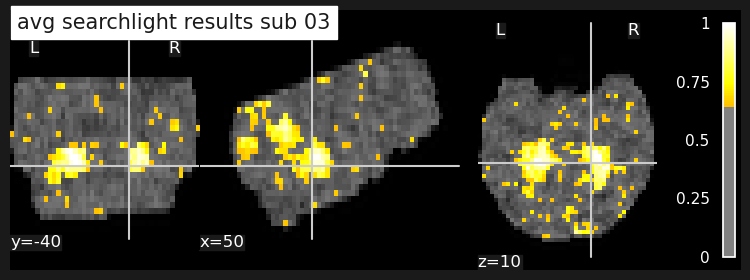

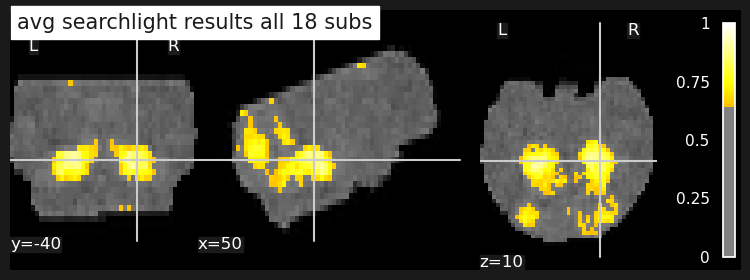

In [36]:
# Insert code here

# os.chdir use to get to directory, from slack
# nib.load


#'avg-03_whole_brain_SL.nii.gz'
os.chdir('/vast/palmer/home.grace/cmhn_ak2776/palmer_scratch/brainiak_results/searchlight_results')
nib.load('avg-03_whole_brain_SL.nii.gz')
plotting.plot_stat_map('avg-03_whole_brain_SL.nii.gz', bg_img='avg-03_whole_brain_SL.nii.gz', cut_coords=(50,-40,10), title='avg searchlight results sub 03', threshold=0.65, vmax=1)



# Redo this for avg 18
os.chdir('/vast/palmer/home.grace/cmhn_ak2776/cmhn-s23-week07-searchlight-ajkohl/07-searchlight')
nib.load('avg18_whole_brain_SL.nii.gz')
plotting.plot_stat_map('avg18_whole_brain_SL.nii.gz', bg_img='avg18_whole_brain_SL.nii.gz', cut_coords=(50,-40,10), title='avg searchlight results all 18 subs', threshold=0.65, vmax=1)



**Exercise 10:**  <a id="ex10"></a> From your results, what do you infer about the discriminability of faces vs. scenes. Is it localized to a particular brain region?

**A:**  

It is not completely or exclusively localized, it provides evidence for possible distributed processing in discriminating faces and scenes

 <a id="ex11"></a>
**Exercise 11:** How do you figure out which searchlight cube is running on which rank when you run it on cluster? Write a new script called `searchlight_rank.py` to figure this out. Following the `searchlight.py` script as an example, write a new kernel function called `calc_rank` which computes and returns the rank of searchlight cube. *Do not perform any classification in this kernel!* Run it for subject 1 and save the resulting brain map as a nifti file. Then, visualize the brain map as you did above.

*Note: to run this script, you must either make a new slurm script to submit your code, or rename the script called by `submit_searchlight.sh`.*

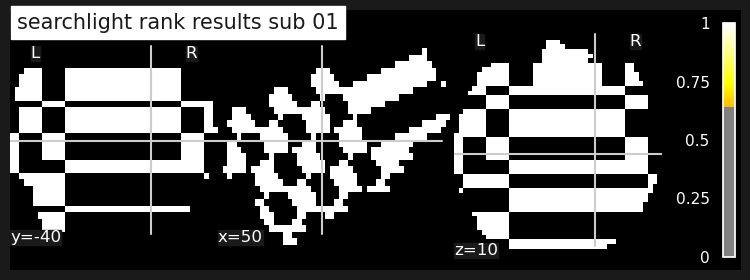

In [24]:
os.chdir('/vast/palmer/home.grace/cmhn_ak2776/palmer_scratch/brainiak_results/searchlight_results')
img = nib.load('/vast/palmer/home.grace/cmhn_ak2776/palmer_scratch/brainiak_results/searchlight_results/rank-01_whole_brain_SL.nii.gz')
img_np = img.get_fdata()
plotting.plot_stat_map('/vast/palmer/home.grace/cmhn_ak2776/palmer_scratch/brainiak_results/searchlight_results/rank-01_whole_brain_SL.nii.gz', bg_img='/vast/palmer/home.grace/cmhn_ak2776/palmer_scratch/brainiak_results/searchlight_results/rank-01_whole_brain_SL.nii.gz', cut_coords=(50,-40,10), title='searchlight rank results sub 01', threshold=0.65, vmax=1)






**A:**  
The work for processing the data loooked to be distributed between ranks and I could see the regions, which were listed.

**Exercise 12:** How many searchlights were run on rank 1?

In [25]:
# Insert code here
np.sum(img_np)

16500.0

 16,500

**Novel contribution:**<a name="novel"></a> be creative and make one new discovery by adding an analysis, visualization, or optimization.

Some ideas for novel contribution:  
- Change the kernel to RSA and correlate it with a model RDM that distinguishes faces and scenes. Compare the RSA results with the decoding results.
- Compute the confusion matrix for each searchlight. You can find useful information about confusion matrix [here](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html).
- Run a searchlight, but not on every voxel. Run searchlights only on every third voxel
- Run each subject on a different rank. BrainIAK searchlight has a way to do that.
- Visualize the accuracy map using surface mapping.

In [26]:
# Insert code here
# Make a mask of only one arbitrary voxel

my_small_mask = np.zeros(whole_brain_mask.shape)
my_small_mask[14:18,18:22,14:18] = 1

# Preset the variables to be used in the searchlight
data = bold_vol
mask = my_small_mask
bcvar = labels
sl_rad = 1
max_blk_edge = 5
pool_size = 1

#Validate your code by uncommenting the following line
np.sum(my_small_mask) == 64

True

In [37]:
# Novel contribution code here
# Insert code here
def my_testing_calc_svm(data, sl_mask, myrad, bcvar):
    
    """
    Parameters:
        data: list of 4D arrays of voxel activation over time
        sl_mask: binary mask specifying the centers of the searchlights
        myrad: an integer describing the radius of the searchlight
        bcvar: the data broadcast to each searchlight. This is used to calculate the kernel
        splits: how many splits are used in StratifiedKFold
        
    Returns: 
        accuracy: average classification accuracy post cross-validation
    """
    
    data4D = data[0]
    labels = bcvar

    Sbolddata = data4D.reshape(sl_mask.shape[0] * sl_mask.shape[1] * sl_mask.shape[2], data[0].shape[3]).T

    nvox = np.sum(sl_mask)

    if nvox < 12:
        return np.nan

    scores = []

    sp = StratifiedKFold(n_splits = 3)

    for train, test in sp.split(Sbolddata, labels):

        trainData = Sbolddata[train,:]
        trainLabel = labels[train]
        testData = Sbolddata[test,:]
        testLabel = labels[test]

        sp_train = StratifiedKFold(n_splits = 3)

        parameters = {'C': [0.01, 0.1, 1, 10]}

        inner_clf = GridSearchCV(
        SVC(kernel='linear'),
        parameters,
        cv=sp_train,
        return_train_score=True)

        inner_clf.fit(trainData, trainLabel)

        C_best_i = inner_clf.best_params_['C']

        classifier = SVC(kernel="linear", C = C_best_i)
        clf = classifier.fit(trainData, trainLabel)

        score = clf.score(testData, testLabel)
        scores.append(score) 

    accuracy = np.mean(scores)

    return accuracy


In [38]:
# Insert code here
from sklearn.model_selection import StratifiedKFold

data = bold_vol
bcvar = labels
sl_rad = 1
max_blk_edge = 5
pool_size = 1

mask = my_small_mask

sl = Searchlight(sl_rad = sl_rad, max_blk_edge = max_blk_edge)

sl.distribute([data], mask)

sl.broadcast(bcvar)

t0 = time.time()

print("Begin Searchlight")
verbose = True

my_sl_result = sl.run_searchlight(my_testing_calc_svm, pool_size=pool_size)
verbose = False
print("Searchlight Completed")

t1 = time.time()

print(f"Average searchlight accuracy: ", np.nanmean(my_sl_result[np.where(my_sl_result)]))
print(f"Standard deviation searchlight accuracy: ",np.nanstd(my_sl_result[mask!=0]))
print("Time elapsed: ", (t1-t0) / 60) 

Begin Searchlight
Searchlight Completed
Average searchlight accuracy:  0.6726190476190476
Standard deviation searchlight accuracy:  0.1895438491439364
Time elapsed:  0.07946292956670126


In [39]:
def calc_rank(data, sl_mask, myrad, bcvar):
    
    comm = MPI.COMM_WORLD
    rank = comm.rank
    
    return np.array([rank])

data = bold_vol
bcvar = labels
sl_rad = 1
max_blk_edge = 5
pool_size = 1

mask = my_small_mask

sl = Searchlight(sl_rad = sl_rad, max_blk_edge = max_blk_edge)

sl.distribute([data], mask)

sl.broadcast(bcvar)

t0 = time.time()

print(f"Begin Searchlight in rank {rank}")
all_sl_result = sl.run_searchlight(calc_rank, pool_size=pool_size)
print(f"End Searchlight in rank {rank}")

t1 = time.time()

print(f"Average searchlight accuracy: ", np.nanmean(my_sl_result[np.where(my_sl_result)]))
print(f"Standard deviation searchlight accuracy: ",np.nanstd(my_sl_result[mask!=0]))
print("Time elapsed: ", (t1-t0) / 60) 

Begin Searchlight in rank 0
End Searchlight in rank 0
Average searchlight accuracy:  0.6726190476190476
Standard deviation searchlight accuracy:  0.1895438491439364
Time elapsed:  4.5363108317057295e-05


Using calc_rank to do the searchlight instead of svm netted a much much faster time with the same searchlight accuracy.

## Contributions <a id="contributions"></a> 

M. Kumar, C. Ellis and N. Turk-Browne produced the initial notebook 03/2018  
T. Meissner minor edits  
H. Zhang preprocessed dataset, add multi-subject section, add multiple exercises, add solutions, other edits  
Vineet Bansal provided the MPI diagrams.  
David Turner provided extensive input on how to use MPI for efficient running of jobs.  
M. Kumar added MPI information and enhanced section contents.  
K.A. Norman provided suggestions on the overall content and made edits to this notebook.  
C. Ellis implemented updates from cmhn-s19.<br/>
X. Li changed nipype function get_data() to get_fdata() since get_data() is deprecated in section 1.1.1      
T. Yates made edits for cmhn_s21.  
E. Busch edited commenting and hardcoding for cmhn-s22, adjusted for Grace cluster and changed submit scripts in cmhn-s23 